In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import stats
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import gseapy as gp
import matplotlib.colors as mcolors

from bin import utils

In [6]:
scdata = sc.read_h5ad("./RNA/sc.B03903E6.clustered.h5")

In [9]:
sc.tl.rank_genes_groups(scdata, groupby="leiden")

In [10]:
pval_cutoff = 0.01
top_n = 200

result = scdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < 0.01]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
top_genes_df.to_csv('DEG.csv', index=False, sep="\t")
top_genes_df

,Gene,Log2FoldChange,padj,score,Cluster
0,Pdcd1,1.493980,2.510187e-217,33.619644,0
1,Nr4a2,1.612693,2.190090e-192,31.504761,0
2,Lyst,1.703999,3.425487e-183,31.001514,0
3,Filip1,2.033433,2.935015e-179,30.800089,0
4,Igfbp7,2.319916,1.093290e-168,29.915075,0
...,...,...,...,...,...
795,Calm2,1.016317,3.975094e-59,18.357323,3
796,Swi5,0.938726,6.444645e-60,18.334259,3
797,Hsp90aa1,1.055475,3.279820e-59,18.322191,3
798,Hprt,1.045844,2.992895e-59,18.288235,3


In [18]:
guide_names = scdata.var_names[scdata.var.feature_types == "CRISPR Guide Capture"]
gdata = scdata[:, guide_names].copy()

guide_names = scdata.var_names[~(scdata.var.feature_types == "CRISPR Guide Capture")]
fdata = scdata[:, guide_names].copy()

In [53]:
def beta_regression(rnadata, guidedata, expr_term=[], expr_layer=None, \
    alpha_list=[0.001, 0.005, 0.01, 0.05, 0.1], max_iter=10000, l1_ratio=0.5):

    """
    Usage:
        beta regression
    Returns:
        dataframe of beta vector
    """

    from sklearn.linear_model import ElasticNet
    from sklearn.model_selection import GridSearchCV
    if len(rnadata.obs_names) != len(guidedata.obs_names):
        print("Error!, data bin count doesn't match!")
        return None
    if type(guidedata.X) == "scipy.sparse._csr.csr_matrix":
        guide_matrix = guidedata.X.toarray()
    else:
        guide_matrix = guidedata.X
    
    if all([obj in rnadata.obs for obj in expr_term]):
        print("Extracting bin metric")
        score_df = rnadata.obs[expr_term]
        try:
            score_matrix = np.array(score_df.astype(int))
        except:
            print("Error converting obs to np.float matrix!")
            return None
    elif all([obj in rnadata.var_names for obj in expr_term]):
        print("Extracting expression metric")
        if not expr_layer:
            if type(rnadata.X) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].X.toarray().T
            else:
                score_matrix = rnadata[:, expr_term].X.T
        else:
            if type(rnadata.layer[expr_layer]) == "scipy.sparse._csr.csr_matrix":
                score_matrix = rnadata[:, expr_term].layer[expr_layer].toarray().T
            else:
                score_matrix = rnadata[:, expr_term].layer[expr_layer].T
    
    corr_matrix = np.zeros((70, 769))
    print("Regressing with " + str(guide_matrix.shape[0]) + " samples, " + str(guide_matrix.shape[1]) +\
        " guides, " + str(score_matrix.shape[1]) + " objectives.")
    param_grid = { 'alpha': alpha_list }
    range_ = range(guide_matrix.shape[1])
    for i in tqdm(range_):
        guide_vector = guide_matrix[:, i]
        regr=ElasticNet(max_iter=max_iter, l1_ratio=l1_ratio)
        grid_regr = GridSearchCV(regr, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=0)
        #print(score_matrix.shape, guide_vector.shape)
        grid_regr.fit(y=score_matrix.toarray().T, X=guide_vector)
        regr = grid_regr.best_estimator_
        regr.fit(y=score_matrix.toarray().T, X=guide_vector)
        corr_matrix[i] = regr.coef_.flatten()
    corr_df = pd.DataFrame(corr_matrix, index=guidedata.var_names, columns=expr_term)
    print("Regression done!")
    return corr_df

In [54]:
df = beta_regression(fdata, gdata, expr_term=deg, alpha_list=[0.05])

Extracting expression metric
Regressing with 4546 samples, 70 guides, 4546 objectives.


  0%|          | 0/70 [00:00<?, ?it/s]

100%|██████████| 70/70 [00:27<00:00,  2.51it/s]

Regression done!


/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


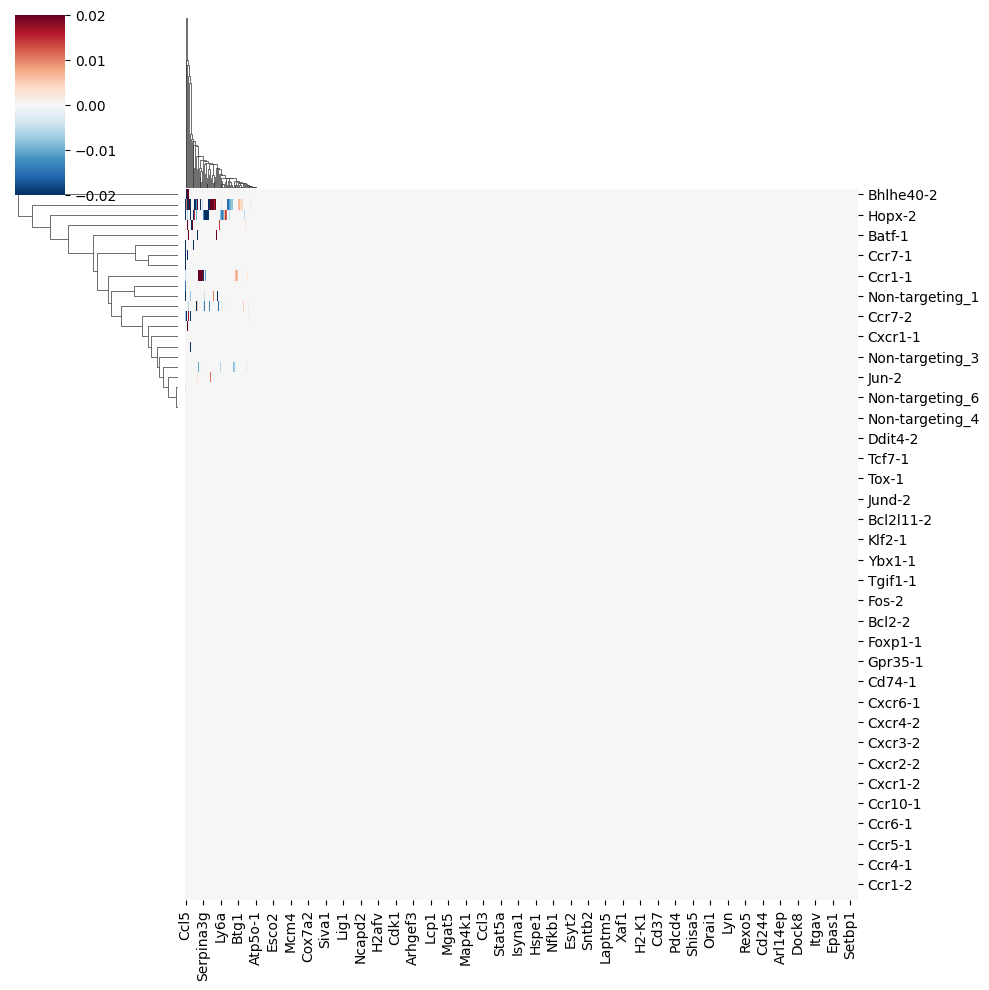

In [61]:
sns.clustermap(df, cmap='RdBu_r', vmax=0.02, vmin=-0.02)